## Importación de dataloaders y pasos previos necesarios

In [1]:
import glob
import pickle
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse
from sklearn.utils import shuffle
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selección GPU / CPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

Los dataloaders utilizados 'updated_val_loader_final' y 'updated_train_loader_' son los distintos dataloaders obtenidos tras la resolución del problema inverso, los cuales se construyeron en distintos dataloaders debido al alto coste computacional de la realización de las operaciones iterando sobre cada elemento. 

In [1]:
#Definición de un Dataset personalizado para poder menejar los y construir los dataloaders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        item = {
            'coherence_matrix': torch.tensor(self.data['coherence_matrix'][index]),
            'class_label': torch.tensor(self.data['class_label'][index]),
            'age': torch.tensor(self.data['age'][index])
        }
        return item

    def __len__(self):
        return len(self.data['coherence_matrix'])

# Unión de los distintos dataloaders de entrenamiento en uno solo
directorio_actual = './'
patron = '../dataloaders/updated_train_loader_*.pkl'
datasets = []

archivos_pkl = glob.glob(f"{directorio_actual}/{patron}")
for archivo_pkl in archivos_pkl:
    with open(archivo_pkl, 'rb') as file:
        dataloader = pickle.load(file)
        datasets.append(dataloader.dataset)

concat_dataset = ConcatDataset(datasets)
train_dataloader = DataLoader(concat_dataset, batch_size=2, shuffle=True)


# Unión de los distintos dataloaders de validación en uno solo
directorio_actual = './'
patron = '../dataloaders/updated_val_loader_final*.pkl'
datasets = []

archivos_pkl = glob.glob(f"{directorio_actual}/{patron}")
for archivo_pkl in archivos_pkl:
    with open(archivo_pkl, 'rb') as file:
        dataloader = pickle.load(file)
        datasets.append(dataloader.dataset)

concat_dataset = ConcatDataset(datasets)
val_dataloader = DataLoader(concat_dataset, batch_size=1, shuffle=True)

## SVM Coherence Matrix

### Preparación de elementos X e Y para la grid search

In [22]:

#==============================PREPARACIÓN DE LOS DATOS DE ENTRENAMIENTO=============================

reduced_matrix_train = []
class_label_train = []
age_train = []

for batch in train_dataloader:
    reduced_matrix = batch['coherence_matrix'].float().numpy()
    class_label = batch['class_label'].numpy()
    age = batch['age'].float().numpy()

    reduced_matrix_train.append(reduced_matrix)
    class_label_train.append(class_label)
    age_train.append(age)
    
reduced_matrix_train = np.concatenate(reduced_matrix_train)
class_label_train = np.concatenate(class_label_train)
age_train = np.concatenate(age_train)
age_train_expanded = np.repeat(age_train[:, np.newaxis], reduced_matrix_train.shape[1], axis=1)

inputs_train = np.concatenate((reduced_matrix_train, age_train_expanded), axis=2)
inputs_train = inputs_train.reshape(inputs_train.shape[0], -1)



#==============================PREPARACIÓN DE LOS DATOS DE VALIDACIÓN=============================


reduced_matrix_val = []
class_label_val = []
age_val = []

for batch in val_dataloader:
    reduced_matrix = batch['coherence_matrix'].float().numpy()
    class_label = batch['class_label'].numpy()
    age = batch['age'].float().numpy()

    reduced_matrix_val.append(reduced_matrix)
    class_label_val.append(class_label)
    age_val.append(age)
    
reduced_matrix_val = np.concatenate(reduced_matrix_val)
class_label_val = np.concatenate(class_label_val)
age_val = np.concatenate(age_val)
age_val_expanded = np.repeat(age_val[:, np.newaxis], reduced_matrix_val.shape[1], axis=1)

inputs_val = np.concatenate((reduced_matrix_val, age_val_expanded), axis=2)
inputs_val = inputs_val.reshape(inputs_val.shape[0], -1)

C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'coherence_matrix': torch.tensor(self.data['coherence_matrix'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'class_label': torch.tensor(self.data['class_label'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'age': torch.tensor(self.data['age'][index])


### Grid Search

In [23]:
param_grid = {
    'base_estimator__kernel': ['linear', 'rbf', 'poly'],
    'base_estimator__C': [0.1, 1, 10],
    'n_estimators': [50, 100, 150]
}

svm_classifier = SVC()

grid_search = GridSearchCV(estimator=BaggingClassifier(base_estimator=svm_classifier, random_state=42),
                           param_grid=param_grid, cv=5)

grid_search.fit(inputs_train, class_label_train)

best_params = grid_search.best_params_

best_kernel = best_params['base_estimator__kernel']
best_C = best_params['base_estimator__C']
best_n_estimators = best_params['n_estimators']

best_svm_classifier = SVC(kernel=best_kernel, C=best_C)
best_bagging_classifier = BaggingClassifier(base_estimator=best_svm_classifier, n_estimators=best_n_estimators, random_state=42)
best_bagging_classifier.fit(inputs_train, class_label_train)

train_predictions = best_bagging_classifier.predict(inputs_train)
validation_predictions = best_bagging_classifier.predict(inputs_val)

train_accuracy = accuracy_score(class_label_train, train_predictions) * 100
validation_accuracy = accuracy_score(class_label_val, validation_predictions) * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {validation_accuracy:.2f}%")

print("Best Parameters:")
print(f"Kernel: {best_kernel}")
print(f"C: {best_C}")
print(f"n_estimators: {best_n_estimators}")

with open("best_params.txt", "w") as file:
    file.write("Best Parameters:\n")
    file.write(f"Kernel: {best_kernel}\n")
    file.write(f"C: {best_C}\n")
    file.write(f"n_estimators: {best_n_estimators}\n")

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:

C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hernandez\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 79.83%
Validation Accuracy: 79.83%
Best Parameters:
Kernel: linear
C: 1
n_estimators: 100


### Validación final con los datos de prueba

C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'coherence_matrix': torch.tensor(self.data['coherence_matrix'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'class_label': torch.tensor(self.data['class_label'][index]),
C:\Users\hernandez\AppData\Local\Temp\ipykernel_14488\2815574410.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'age': torch.tensor(self.data['age'][index])


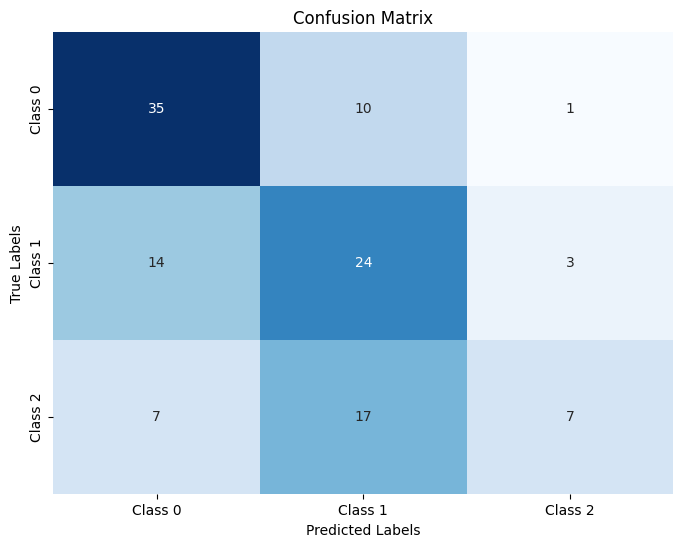

,Metric,Value
0,Accuracy,0.559322
1,Precision,0.577317
2,Recall,0.524014
3,F1 Score,0.513782


In [28]:
#Carga del dataloader de test
directorio_actual = './'
patron_test = '../dataloaders/updated_test_loader_final*.pkl'
datasets_test = []

archivos_pkl_test = glob.glob(f"{directorio_actual}/{patron_test}")
for archivo_pkl in archivos_pkl_test:
    with open(archivo_pkl, 'rb') as file:
        dataloader_ii = pickle.load(file)
        datasets_test.append(dataloader_ii.dataset)

#Unión de los distintos dataloaders en uno solo
concat_dataset = ConcatDataset(datasets_test)
test_dataloader = DataLoader(concat_dataset, batch_size=1, shuffle=False)


#==============================PREPARACIÓN DE LOS DATOS DE PRUEBA====================================

reduced_matrix_test = []
class_label_test = []
age_test = []

for batch in test_dataloader:
    reduced_matrix = batch['coherence_matrix'].float().numpy()
    class_label = batch['class_label'].numpy()
    age = batch['age'].float().numpy()

    reduced_matrix_test.append(reduced_matrix)
    class_label_test.append(class_label)
    age_test.append(age)
    
reduced_matrix_test = np.concatenate(reduced_matrix_test)
class_label_test = np.concatenate(class_label_test)
age_test = np.concatenate(age_test)
age_test_expanded = np.repeat(age_test[:, np.newaxis], reduced_matrix_test.shape[1], axis=1)

inputs_test = np.concatenate((reduced_matrix_test, age_test_expanded), axis=2)
inputs_test = inputs_test.reshape(inputs_test.shape[0], -1)


test_predictions = best_bagging_classifier.predict(inputs_test)

#=====================================CÁLCULO DE MÉTRICAS============================================

accuracy = metrics.accuracy_score(class_label_test, test_predictions)
precision = metrics.precision_score(class_label_test, test_predictions, average='macro')
recall = metrics.recall_score(class_label_test, test_predictions, average='macro')
f1 = metrics.f1_score(class_label_test, test_predictions, average='macro')

metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                           'Value': [accuracy, precision, recall, f1]})

confusion_matrix = metrics.confusion_matrix(class_label_test, test_predictions)

confusion_df = pd.DataFrame(confusion_matrix)

class_labels = ['Class 0', 'Class 1', 'Class 2']


# Visualización de las métricas y la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
metrics_df